In [2]:
import os
import os.path
import io
import pandas as pd
import numpy as np
import cv2
import time
from tqdm import tqdm
from zipfile import ZipFile

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
import seaborn as sns

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import sys
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import preprocessing

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
RANDOM_SEED = 42

IMG_WIDTH = 75
IMG_HEIGHT = 75
IMG_CHANNELS = 1

IMG_SHAPE = [IMG_WIDTH, IMG_HEIGHT]
IMG_LENGTH = IMG_WIDTH * IMG_HEIGHT

def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [4]:
def label_img(img_name):
  if 'cat' in img_name: return [1, 0]
  elif 'dog' in img_name: return [0, 1]

In [5]:
train = "train.zip"

training_data = []

with ZipFile(train, 'r') as z:
  for fn in tqdm(z.namelist()):
    if not os.path.isdir(fn) and fn.endswith("jpg"):
      label = label_img(fn)

      img_str = z.read(fn)

      nparr = np.frombuffer(img_str, np.uint8)

      img_np = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img_np, (IMG_WIDTH, IMG_HEIGHT))

      training_data.append([ np.array(img), np.array(label)])

100%|██████████| 25001/25001 [00:23<00:00, 1056.83it/s]


In [6]:
training_data[0]

[array([[170, 174, 181, ..., 214, 210, 206],
        [170, 174, 181, ..., 216, 212, 208],
        [170, 175, 181, ..., 217, 215, 210],
        ...,
        [129, 133, 135, ...,   3,   3,   2],
        [127, 129, 131, ...,   3,   3,   2],
        [124, 128, 131, ...,   2,   2,   2]], dtype=uint8), array([1, 0])]

In [7]:
def peek_img( index, data = training_data):
  img_type = 'Unknown'
  
  if np.array_equal(data[index][1], [1, 0]): img_type = 'Cat'
  elif np.array_equal(data[index][1], [0, 1]): img_type = 'Dog'
  
  imshow(data[index][0], cmap = 'gray', interpolation = 'bicubic')
  plt.title(img_type)
  plt.show()

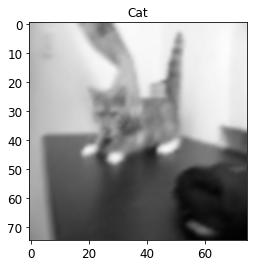

In [8]:
peek_img(0)

In [9]:
dog_index = -1

for i, x in enumerate(training_data):
  if np.array_equal(x[1], [0, 1]):
    dog_index = i
    break

dog_index

12500

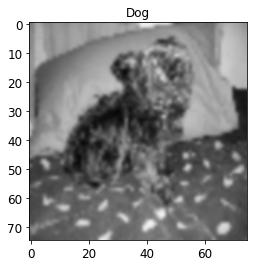

In [10]:
peek_img(dog_index)

In [11]:
def plot_images(images, cls_true, indexes = None, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.5, wspace=1.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(IMG_SHAPE), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis, and the image index on the y-axis.
        ax.set_xlabel(xlabel)
        
        if indexes != None:
          ax.set_ylabel(indexes[i])
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [12]:
def plot_indexes(indexes):
  subset = [training_data[i] for i in indexes]

  images = []
  labels = []

  for i in subset:
    x, y = i

    images.append(x)

    if np.array_equal(y, [1, 0]): labels.append('Cat')
    elif np.array_equal(y, [0, 1]): labels.append('Dog')

  plot_images(images, labels, indexes)

In [13]:
import random

indexes = []

for x in range(9):
  indexes.append(random.randint(0, len(training_data)))

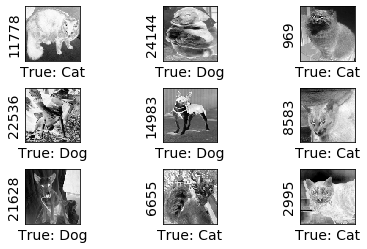

In [14]:
plot_indexes(indexes)

In [15]:
from random import shuffle 

shuffle(training_data)

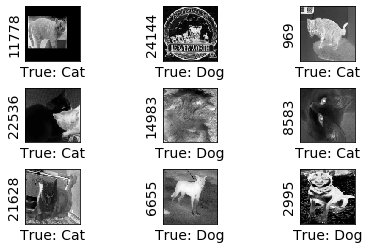

In [16]:
plot_indexes(indexes)

In [17]:
train_size = int(len(training_data) * .8)
train_size

20000

In [18]:
train = training_data[-train_size:]
display('Train Size: {}'.format(len(train)))

validation = training_data[:-train_size]
display('Validation Size: {}'.format(len(validation)))

'Train Size: 20000'

'Validation Size: 5000'

In [19]:
X_train = np.array([i[0] for i in train]).reshape(-1,IMG_WIDTH, IMG_HEIGHT,1)
y_train = np.array([i[1] for i in train])

X_val = np.array([i[0] for i in validation]).reshape(-1,IMG_WIDTH, IMG_HEIGHT,1)
y_val = np.array([i[1] for i in validation])

In [20]:
mysize=75 #image size
mybatch=32 #batch size
trainingsteps=np.ceil(20000)
valstep=np.ceil(5000)
#trainingsteps=np.ceil(20000/mysize)
#valsteps=np.ceil(5000/mysize)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(mysize, mysize, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) #flatten for forecasting
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation="softmax"))


model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#history=model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0

In [65]:
test = "test.zip"

test_data = []

with ZipFile(test, 'r') as z:
  for fn in tqdm(z.namelist()):
    if not os.path.isdir(fn) and fn.endswith("jpg"):
      label = label_img(fn)

      img_str = z.read(fn)

      nparr = np.frombuffer(img_str, np.uint8)

      img_np = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img_np, (IMG_WIDTH, IMG_HEIGHT))

      test_data.append([ np.array(img), np.array(label)])

100%|██████████| 12501/12501 [00:11<00:00, 1088.87it/s]


In [66]:
X_test = np.array([i[0] for i in test_data]).reshape(-1,IMG_WIDTH, IMG_HEIGHT,1)
y_test = np.array([i[1] for i in test_data])

In [67]:
y_pred = model.predict_classes(X_test)
print(y_pred[:2])

df_cnn1=pd.DataFrame({'id' : pd.Series(range(1,12501)), 'label': y_pred})
df_cnn1.to_csv('cnn1.csv', index=False)

#Kaggle 17.18670
#2899 seconds = ~48 minutes

[0 0]
